## Project : Exploring the Canada's milk imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2018:

- How much does the Canada export and import and is the balance positive (more exports than imports)?
- Which are the main trading partners, i.e. from/to which countries does Canada import/export the -most?
- Which are the regular customers, i.e. which countries buy milk from Canada every month?
- Which countries does Canada both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

##  Getting and preparing the data
The data is obtained from the United Nations Comtrade website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly
- Periods: January to December of 2018
- Reporter: Canada
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)
- Which was downloaded using csv and saved appropriately

In [2]:
LOCATION = 'comtrade_canada_2018_monthly.csv'

**On reading in the data, the commodity code has to be read as a string,  to not lose the leading zero.**

In [3]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
516,HS,2018,201801,Jan-18,4,0,1,Imports,124,Canada,...,NaN,NaN,NaN,NaN,1491.0,NaN,2356,NaN,NaN,0
517,HS,2018,201804,Apr-18,4,0,2,Exports,124,Canada,...,NaN,NaN,NaN,NaN,67.0,NaN,66,NaN,NaN,0


**The data only covers the twelve months of 2018.
Most columns are irrelevant for this analysis, 
or contain always the same value, like the year and reporter columns. 
The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.**

In [4]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201809,United States of America,Exports,unknown,454116
1,201804,United States of America,Exports,unknown,600205
2,201808,Saint Pierre and Miquelon,Exports,unknown,267
3,201808,"China, Hong Kong SAR",Exports,unknown,9021
4,201802,Poland,Imports,unknown,3233


**The data contains the total imports and exports per month,
under the 'World' partner. Those rows are removed to keep only the per-country data.**

In [5]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201809,United States of America,Exports,unknown,454116
1,201804,United States of America,Exports,unknown,600205
2,201808,Saint Pierre and Miquelon,Exports,unknown,267
3,201808,"China, Hong Kong SAR",Exports,unknown,9021
4,201802,Poland,Imports,unknown,3233


## Total trade flow
To answer the first question, 
-**'how much does the Canada export and import and is the balance positive (more exports than imports)?'**,
the dataframe is split into two groups: exports from the Canada and imports into the Canada. 
The trade values within each group are summed up to get the total trading.

In [6]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    122457836
Imports     36634284
Name: Trade Value (US$), dtype: int64

* This shows a trade surplus of over 60 million dollars.*

### Main trade partners
To address the second question, **'Which are the main trading partners, i.e. from/to which countries does the Canada import/export the most?'**, the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [7]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('Canada imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to Canada are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

Canada imports from 30 countries.
The 5 biggest exporters to Canada are:


Partner
United States of America    34209343
Denmark                      1145218
Netherlands                   563041
United Kingdom                374242
Germany                       109205
Name: Trade Value (US$), dtype: int64

**The export values can be plotted as a bar chart, making differences between countries easier to see.**

<AxesSubplot:ylabel='Partner'>

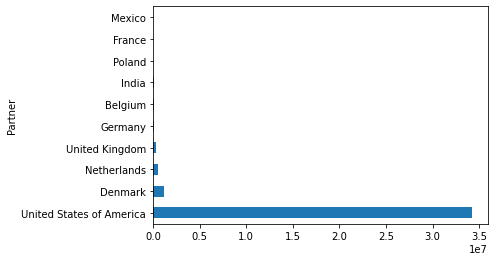

In [8]:
totalImports.head(10).plot(kind='barh')

## Regular importers
Given that there are two commodities, the third question, **'Which are the regular customers, i.e. which countries buy milk from Canada every month?',** is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [9]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('Canada exports to', len(grouped), 'countries.')
print('The 5 biggest importers from Canada are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

Canada exports to 53 countries.
The 5 biggest importers from Canada are:


Partner
Algeria                     30598155
Egypt                       16500765
Philippines                 10773980
United States of America     7420600
Mexico                       7383430
Name: Trade Value (US$), dtype: int64

In [ ]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201801) & (regular[COMMODITY] == 'processed')

In [11]:
regular[VALUE].sum() / exports[VALUE].sum()

0.1480887674676858

**Just over 10% of the total canada exports are due to these regular customers.**

## Bi-directional trade
To address the fourth question, **'Which countries does Canada both import from and export to?'**, a pivot table is used to list the total export and import value for each country.

In [12]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,251715.0,NaN
Algeria,30598155.0,NaN
Argentina,NaN,2.0
Bahamas,104902.0,NaN
Bahrain,40976.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with Canada.

In [16]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
China,912617.0,51.0
"China, Hong Kong SAR",120637.0,12.0
Denmark,122916.0,1145218.0
Egypt,16500765.0,1645.0
France,6010.0,8035.0
Italy,209.0,153.0
Malaysia,4878189.0,3.0
Mexico,7383430.0,4885.0
Philippines,10773980.0,46.0


## Conclusion
The milk and cream trade of Canada from January to December 2018 was analysed in terms of which countries Canada mostly depends on for income (exports) and goods (imports). Over the period, Canada had a trade surplus of over 60 million US dollars.

United States of America is the main partner, Canada exports from United States America almost the triple in value than it imports from Canada.

Canada exported to over 53 countries during the period, but only imported from 30 countries, the main ones (top five by trade value) being geographically close. Denmark and Netherlands are the main importers that are not also main exporters.

The UK is heavily dependent on its regular customers, the 12 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.